### Step 1: Importing the QFlow class
In Python 3.6 this might return a warning but it can be ignored (it does not affect the accuracy or performance).

In [1]:
# import the QFlow class
import os 
import QFlow_class
qf = QFlow_class.QFlow()

/Users/jpz1/anaconda/envs/TFenv/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Step 2: Create the random subregions for training
This cell needs to be run only once, as it stores created training data set locally in the `Data/sub_images`. Argument `sub_size` allows to set the subregion size. It needs to be consistent with the `cnn_model_fn`. 

The progress of extracting and slicing data is visualized with a progress bar. Total time to generate 10 subregions, 30 x 30 pixels, per each data file on a 2017 MacBook Pro is about 7 minutes.


In [2]:
# define the size of subregions
sub_size = 30

In [3]:
# give a path to where the raw_data.zip file is -- if the raw_data.zip file is in the same folder as QFlow training use 
path_data = os.getcwd()

In [4]:
# create the files for training, 10 subregions per image 
# this needs to be executed only once
qf.slice_data(sub_size = sub_size, path_data = path_data)

False
Extracting raw_data.zip
Progress: |██████████████████████████████████████████████████| 100.0% Complete
raw_data.zip is now extracted
Generating subregions
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Done generating subregions


### Step 2a: Previewing the subregions
This cell allows to preview the training data together with the label for a given subregion. The format of the label is `[SC, QPC, SD, DD]` and it represents the percentage of the subregion area taken by a gien state.  

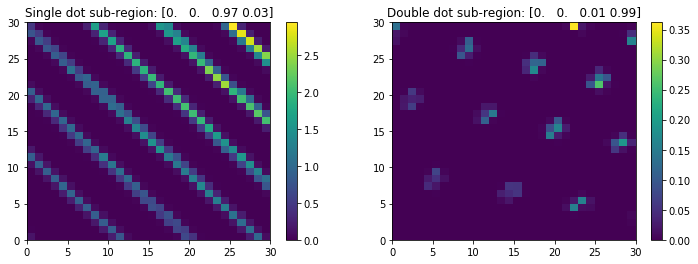

In [5]:
qf.data_preview()

### Step 3: Definition of the learning network

Network parameters, such as the number of convolutional and pooling layers and the number and size of dense layers can be modified to improve the performance of the network. With the default architecture, on a 2017 MacBook Pro the network trains on 30 x 30 pixel subregions to the accuracy of about 96% in about 10 minutes, with accuracy defined as the percentage of correctly classified subregions.


In [6]:
"""Convolutional Neural Network Estimator for 5-gates device."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import glob
import os

tf.logging.set_verbosity(tf.logging.INFO)
    
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    input_layer = tf.cast(tf.reshape(features["x"], [-1, sub_size, sub_size, 1]), tf.float32)

    # Convolutional Layer
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",        # preserves width and height
        activation=tf.nn.relu)

    # Pooling Layer
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Flatten tensor into a batch of vectors
    pool2_flat = tf.contrib.layers.flatten(pool1)

    # Dense Layers
    dense0 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout0 = tf.layers.dropout(inputs=dense0, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    dense1 = tf.layers.dense(inputs=dropout0, units=512, activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    dense2 = tf.layers.dense(inputs=dropout1, units=128, activation=tf.nn.relu)
    dropout2 = tf.layers.dropout(inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout2, units=4)

    predictions = {
        "state": tf.argmax(input=logits, axis=1),
        "probabilities": tf.cast(tf.nn.softmax(logits , name="softmax_tensor"), tf.float64)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.mean_squared_error(labels=labels, predictions=tf.nn.softmax(logits))
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
        
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=tf.argmax(labels, axis=1), \
                                                       predictions=predictions["state"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Step 4: Execution of training and evaluation on simulated data

The code reads the subregion data and splits it into two sets (90% for training, 10% for evaluation). Then, using the `cnn_model_fn`, the network is trained to distinguish between single dots, double dots, short circuit and barrier states. The trained network is stored in the `Data/trained_model` folder (created during training). To re-train the network on a new data set this folder needs to be removed or emptied. The outcome from the network is a probability vector in the format `[SC, QPC, SD, DD]`. 

In [7]:
# create the estimator and a place to store the trained network
state_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="Data/trained_model")

#train the network
qf.train_net(classifier=state_classifier, batch_size=50, steps=5000)
qf.eval_net(classifier=state_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Data/trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1819ec61d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Total number of samples : 10010
Training samples : 9009
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into Data/trained_model/model.ckp

INFO:tensorflow: (4.601 sec)
INFO:tensorflow:global_step/sec: 10.9452
INFO:tensorflow: (4.534 sec)
INFO:tensorflow:loss = 0.0006410919, step = 4601 (9.136 sec)
INFO:tensorflow: (4.450 sec)
INFO:tensorflow:global_step/sec: 10.9472
INFO:tensorflow: (4.685 sec)
INFO:tensorflow:loss = 0.0014529452, step = 4701 (9.135 sec)
INFO:tensorflow: (4.308 sec)
INFO:tensorflow:global_step/sec: 11.1247
INFO:tensorflow: (4.683 sec)
INFO:tensorflow:loss = 0.0020056374, step = 4801 (8.992 sec)
INFO:tensorflow: (5.145 sec)
INFO:tensorflow:global_step/sec: 10.6474
INFO:tensorflow: (4.246 sec)
INFO:tensorflow:loss = 0.0019336053, step = 4901 (9.389 sec)
INFO:tensorflow: (5.256 sec)
INFO:tensorflow:Saving checkpoints for 5000 into Data/trained_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0011773058.
Total number of samples : 10010
Evaluating samples: 1001
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-04-08:21:42
INFO:tensor

### Step 5: Visualization of the classification accuracy for evaluation
A histogram showing the comparison of true data labels from the evaluation set (evals) and the labels predicted by the trained network (preds). The vertical axis represents the number of images.

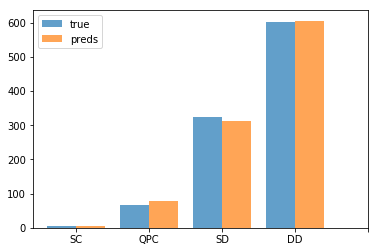

In [8]:
qf.evaluation_visual()

### Step 6: Evaluation of the trained network on experimental data

The code reads the provided experimental data from a folder `Data/exp_data` and then applies the trained network to classify each image. The README file explains how data needs to be formated to be compatible with the network.  

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Data/trained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c25a50d68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Data/trained_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


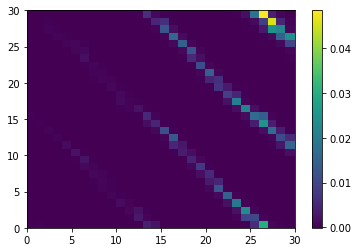

This image is classified as a sinlge dot (sub-region label:  [0.   0.02 0.54 0.45]).



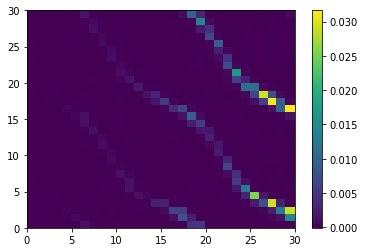

This image is classified as a sinlge dot (sub-region label:  [0.   0.19 0.47 0.34]).



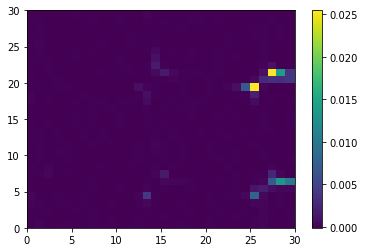

This image is classified as a double dot (sub-region label:  [0.  0.  0.1 0.9]).



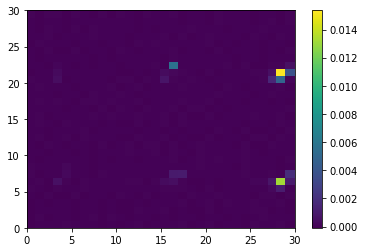

This image is classified as a double dot (sub-region label:  [0.   0.03 0.43 0.54]).



In [9]:
# assign the estimator
state_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="Data/trained_model")

# evaluate the experimental data
exp_preds = qf.eval_exp(scaling = 10**2, classifier=state_classifier)
qf.exp_visual(exp_preds = exp_preds)